Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


{'Crisis 52-55': slice(1952, 1955, None), 'Expansión 56-69': slice(1956, 1969, None), 'Recesión 70-81': slice(1970, 1981, None), 'Crisis 82-85': slice(1982, 1985, None), 'Expansión 86-99': slice(1986, 1999, None), 'Crisis 00-05': slice(2000, 2005, None), 'Expansión 06-13': slice(2006, 2013, None), 'Recesión 14-24': slice(2014, 2024, None)}


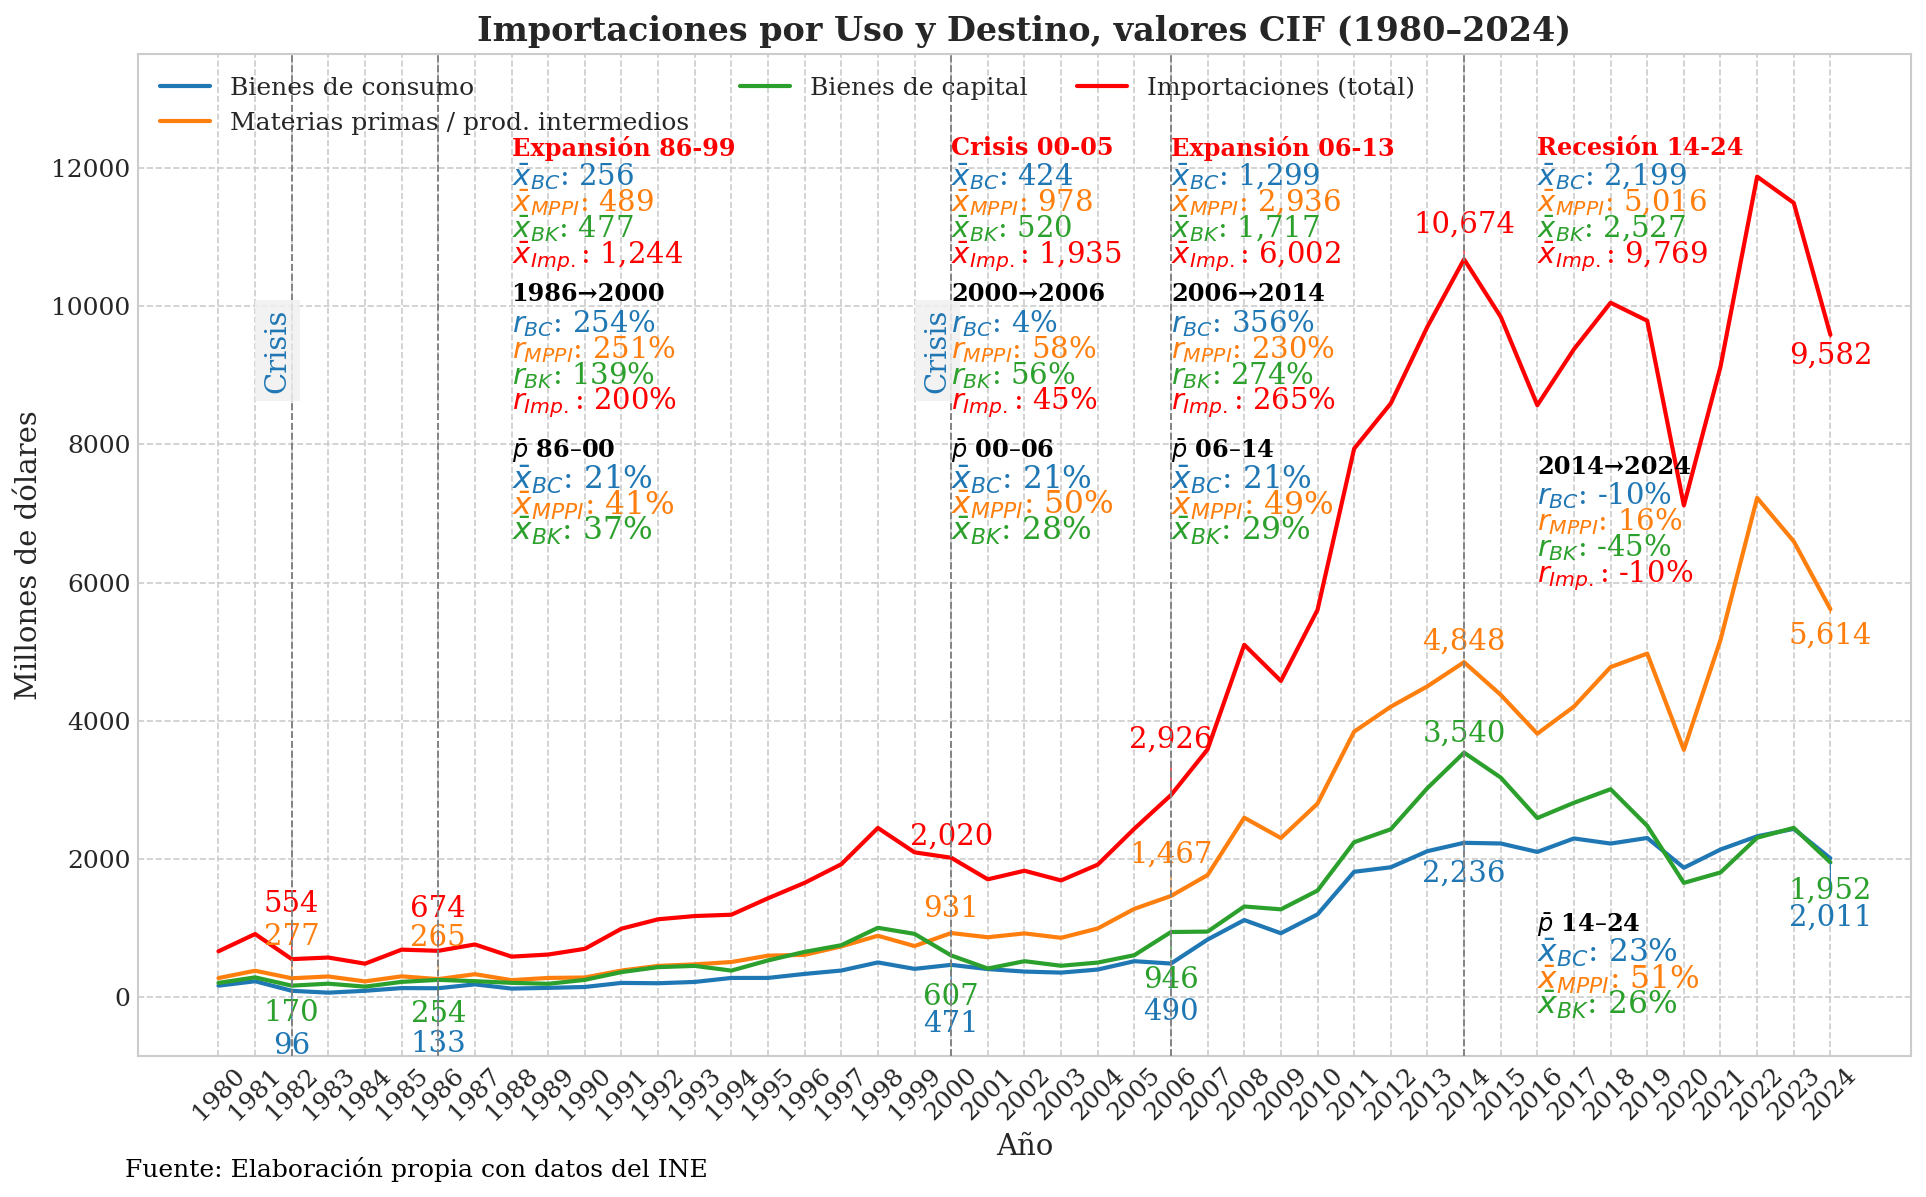

In [7]:
# ─────────────────────────────────────────────────────────────────────
# Imports
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))  # utilidades propias
from graficos_utils import *
from config import *
print(CYCLES)
# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/importaciones"
os.makedirs(output_dir, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM composicion_importaciones_uso_destino', conn)
            .set_index('año')
            .sort_index())
    df.rename(columns={'total_valor_oficial_cif': 'importaciones'}, inplace=True)

# Componentes y columnas
componentes = [
    ('bienes_consumo', 'Bienes de consumo'),
    ('materias_primas_productos_intermedios', 'Materias primas / prod. intermedios'),
    ('bienes_capital', 'Bienes de capital'),
    ('importaciones', 'Importaciones (total)'),
]
cols_componentes = [col for col, _ in componentes]

# Abreviaturas
abbr_map = {
    'bienes_consumo': 'BC',
    'materias_primas_productos_intermedios': 'MPPI',
    'bienes_capital': 'BK',
    'importaciones': 'Imp.'
}

# ─────────────────────────────────────────────────────────────────────
# Preparación
# ─────────────────────────────────────────────────────────────────────
annotate_years    = adjust_annot_years(df, annot_years)
CYCLES            = adjust_cycles(df, CYCLES)
cycle_stats       = {name: df.loc[period, cols_componentes].mean().to_dict()
                     for name, period in CYCLES.items()}
periodos          = adjust_periods(df, periodos_tasas)
custom_colors     = {
    'bienes_consumo': '#1f77b4',
    'materias_primas_productos_intermedios': '#ff7f0e',
    'bienes_capital': '#2ca02c',
    'importaciones': 'red',
}

# ─────────────────────────────────────────────────────────────────────
# Offsets
# ─────────────────────────────────────────────────────────────────────
annotation_offsets = {
    'bienes_consumo': {
        1982: (0, -800), 1986: (0, -800), 2000: (0, -850),
        2006: (0, -700), 2014: (0, -450), 2024: (0, -850),
    },
    'materias_primas_productos_intermedios': {
        1982: (0, 600), 1986: (0, 600), 2000: (0, 350),
        2006: (0, 600), 2014: (0, 300), 2024: (0, -380),
    },
    'bienes_capital': {
        1982: (0, -400), 1986: (0, -500), 2000: (0, -600),
        2006: (0, -700), 2014: (0, 280), 2024: (0, -400),
    },
    'importaciones': {
        1982: (0, 800), 1986: (0, 600), 2000: (0, 300),
        2006: (0, 800), 2014: (0, 500), 2024: (0, -300),
    },
}
hitos_offset = {a: 0.8 for a in hitos_v}
medias_offset = {
    'Expansión 86-99': (1988, 1),
    'Crisis 00-05': (2000, 1),
    'Expansión 06-13': (2006, 1),
    'Recesión 14-24': (2016, 1),
}
tasas_offsets = {
    '1986-2000': (1988, 0.83),
    '2000-2006': (2000, 0.83),
    '2006-2014': (2006, 0.83),
    '2014-2024': (2016, 0.63),
}
participacion_offsets = {
    '1986-2000': (1988, 0.65),
    '2000-2006': (2000, 0.65),
    '2006-2014': (2006, 0.65),
    '2014-2024': (2016, 0.1),
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "Importaciones por Uso y Destino, valores CIF (1980–2024)",
    "Año",
    "Millones de dólares",
    source_text="Fuente: Elaboración propia con datos del INE"
)

add_hitos(
    ax, df.index, hitos_v, hitos_offset,
    line_kwargs={'linewidth': 0.9}
)
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offset,
    abbr_map, custom_colors,
    line_spacing
)

add_year_value_annotations(
    ax, df, annotate_years,
    cols_componentes, annotation_offsets,
    custom_colors, arrow_lw=0.5
)

add_period_growth_annotations_multi(
    ax, df, periodos,
    cols_componentes, tasas_offsets,
    custom_colors, abbr_map
)

add_participation_cycle_boxes(
    ax, df, periodos,
    ['bienes_consumo', 'materias_primas_productos_intermedios', 'bienes_capital'],
    'importaciones', participacion_offsets,
    abbr_map=abbr_map, colors=custom_colors
)

ax.set_ylim(-850, df[cols_componentes].max().max() * 1.15)

plt.savefig(os.path.join(output_dir, "importaciones_uso_destino_valores.png"))
plt.show()
